In [134]:
#Author: Venkat
#Description: Robinhood assignment
#Date: 07/03

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.feature_selection._base import SelectorMixin
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.utils import resample
from xgboost import plot_importance
from matplotlib import pyplot

def read_files(path):
    return pd.read_csv(path)


In [135]:
features_data = read_files('/Users/vnk/Downloads/features_data.csv')                      
equity_value_data = read_files('/Users/vnk/Downloads/equity_value_data.csv')

In [136]:
equity_value_data

,timestamp,close_equity,user_id
0,2016-11-16T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
1,2016-11-17T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
2,2016-11-18T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
3,2016-11-21T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
4,2016-11-22T00:00:00Z,48.16,bcef4fa9b0bdf22bcf7deae708decf03
...,...,...,...
1119153,2017-08-14T00:00:00Z,2270.71,98580360c4fb5b0ec511cd87f0d429ed
1119154,2017-08-15T00:00:00Z,2275.02,98580360c4fb5b0ec511cd87f0d429ed
1119155,2017-08-16T00:00:00Z,2282.03,98580360c4fb5b0ec511cd87f0d429ed
1119156,2017-08-17T00:00:00Z,2237.45,98580360c4fb5b0ec511cd87f0d429ed


In [137]:
features_data

,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91
...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a


## a) What percentage of users have churned in the data provided?

In [138]:
total_users = features_data['user_id'].nunique()
print("Total numbers of users:", total_users)

Total numbers of users: 5584


### since equity_value_data contains data of users for days when the equity is >=10, I calculated the difference between the dates and if the difference is greater than 28 then the user is counted as a churn user. (Going by the definition of churn (having <10 balance for 28 calendar days)

In [139]:
equity_value_data['date'] = pd.to_datetime(equity_value_data['timestamp'])
equity_value_data['date'] = equity_value_data.groupby('user_id')['date'].apply(lambda x: x.sort_values())
equity_value_data['diff'] = equity_value_data.groupby('user_id')['date'].diff() / np.timedelta64(1, 'D')
equity_value_data['diff'] = equity_value_data['diff'].fillna(0)

In [140]:
churn_users = equity_value_data[equity_value_data['diff'] > 28]['user_id'].nunique()
print("Total numbers of churn users:", churn_users)
print("Churn percentage: {}%".format(round(churn_users*100/total_users,2)))

Total numbers of churn users: 275
Churn percentage: 4.92%


### Assumption: I have also notices some users had diff >28 but then has added equity and came back to the platform and reduced the diff to <28. I counted these people also as churn since the behavour is exhibited once.

## b) Churn Classifier

In [141]:
churn_user_ids = equity_value_data[equity_value_data['diff'] > 28]['user_id'].unique()
features_data.loc[features_data['user_id'].isin(churn_user_ids), 'churn_label'] = 1
features_data['churn_label'].fillna(0,inplace=True)

In [142]:
features_data['churn_label'].value_counts()

0.0    5309
1.0     275
Name: churn_label, dtype: int64

In [143]:
# Separate majority and minority classes
features_data_majority = features_data[features_data.churn_label==0]
features_data_minority = features_data[features_data.churn_label==1]
 
# Upsample minority class
features_data_minority_upsampled = resample(features_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=5309,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
features_data_upsampled = pd.concat([features_data_majority, features_data_minority_upsampled])
 
# Display new class counts
features_data = features_data_upsampled
features_data_upsampled.churn_label.value_counts()


0.0    5309
1.0    5309
Name: churn_label, dtype: int64

In [144]:
y = features_data['churn_label']
features = features_data.drop(['churn_label','user_id'],1)

In [168]:
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=0.20, random_state=10)

In [169]:
numeric_features = x_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = x_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder="drop")

In [170]:
preprocessor_fit = preprocessor.fit(x_train)
x_train = preprocessor_fit.transform(x_train)
x_test = preprocessor_fit.transform(x_test)

In [171]:
model = XGBClassifier(use_label_encoder=False)
model.fit(x_train, y_train)

[20:28:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [157]:
print(model.feature_importances_)

[0.0459119  0.0485876  0.05469691 0.0387303  0.04954075 0.03745705
 0.04107375 0.03588805 0.06076932 0.05009828 0.06089837 0.07715865
 0.04059878 0.05889909 0.01187477 0.09855812 0.03838293 0.01783844
 0.03541147 0.         0.02115861 0.03748407 0.03898272]


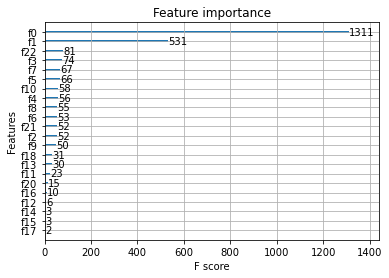

In [158]:
plot_importance(model)
pyplot.show()

### #Accuracy of the model


In [159]:
y_predict = model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.96      1114
         1.0       0.94      0.97      0.96      1010

    accuracy                           0.96      2124
   macro avg       0.96      0.96      0.96      2124
weighted avg       0.96      0.96      0.96      2124



In [160]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()

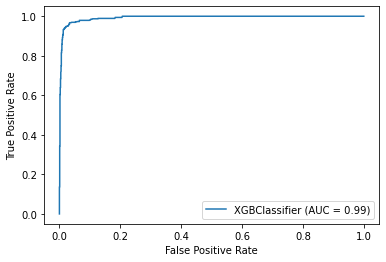

In [161]:
metrics.plot_roc_curve(model, x_test, y_test)  

### Predictions for all users

In [177]:

input_data = preprocessor_fit.transform(features)
predictions = model.predict(input_data)
features_data['predictions'] = predictions
features_data[['user_id','predictions']]

,user_id,predictions
0,895044c23edc821881e87da749c01034,0
1,458b1d95441ced242949deefe8e4b638,0
2,c7936f653d293479e034865db9bb932f,0
3,b255d4bd6c9ba194d3a350b3e76c6393,0
4,4a168225e89375b8de605cbc0977ae91,0
...,...,...
361,5b284610a2d273aaee00e38779136101,1
1488,438340f3612614e3772bed49aaf12dff,1
3119,15712a490a2f4d1c73188de8dbde34d9,1
400,99351e26205e5a0688310b8878675a24,1


## c)Important features

In [162]:
onehot_columns = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))

In [163]:
numeric_features.extend(onehot_columns)
numeric_features

['time_spent',
 'first_deposit_amount',
 'risk_tolerance_low_risk_tolerance',
 'risk_tolerance_med_risk_tolerance',
 'investment_experience_good_investment_exp',
 'investment_experience_limited_investment_exp',
 'investment_experience_no_investment_exp',
 'liquidity_needs_somewhat_important_liq_need',
 'liquidity_needs_very_important_liq_need',
 'platform_both',
 'platform_iOS',
 'instrument_type_first_traded_adr',
 'instrument_type_first_traded_cef',
 'instrument_type_first_traded_etp',
 'instrument_type_first_traded_lp',
 'instrument_type_first_traded_mlp',
 'instrument_type_first_traded_reit',
 'instrument_type_first_traded_rlt',
 'instrument_type_first_traded_stock',
 'instrument_type_first_traded_tracking',
 'instrument_type_first_traded_wrt',
 'time_horizon_med_time_horizon',
 'time_horizon_short_time_horizon']

In [164]:
model = LogisticRegression(solver='lbfgs', class_weight='balanced', penalty='l2', max_iter = 1000)
model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [165]:
y_predict = model.predict(x_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.60      0.61      0.61      1114
         1.0       0.57      0.56      0.56      1010

    accuracy                           0.59      2124
   macro avg       0.59      0.58      0.58      2124
weighted avg       0.59      0.59      0.59      2124



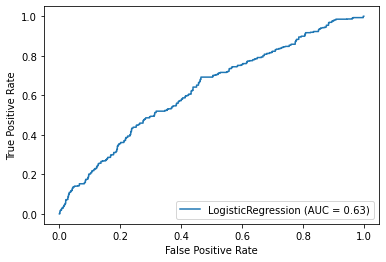

In [166]:
metrics.plot_roc_curve(model, x_test, y_test)  

In [167]:
import eli5
eli5.explain_weights(model, top=50, feature_names=numeric_features, feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+1.076,risk_tolerance_low_risk_tolerance
+0.768,instrument_type_first_traded_wrt
+0.657,instrument_type_first_traded_lp
+0.462,risk_tolerance_med_risk_tolerance
+0.256,platform_both
+0.245,instrument_type_first_traded_etp
+0.213,instrument_type_first_traded_cef
+0.199,investment_experience_limited_investment_exp
+0.170,instrument_type_first_traded_mlp
+0.151,investment_experience_no_investment_exp
